# Clustering Word Co-Occurrences

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys, imp
import numpy as np
import pandas as pd
import re
import random
import math
import nltk
import string
import datetime
import imp

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Clustering
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram
from nltk.corpus import stopwords
from scipy.cluster.hierarchy import fcluster
from statistics import mean

In [2]:
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()

In [3]:
punctuation = set(string.punctuation)

In [4]:
stopwordList = stopwords.words('english')

In [5]:
os.chdir('..') # Change to Top Level GIT Directory

In [6]:
sys.path.append('./prototype_python') # Add location of python prototype to path

In [7]:
sys.path.append('./protest_temporalAnalysis/') # Add location of python prototype to path

In [8]:
import temporal_methods as tm
import semanticDensity as sd
import syntacticParsing as sp

### Tokenize and Pre-Process all Files

In [9]:
dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/protest_temporalAnalysis/data_activists/MLK/raw/'
fileData = tm.getSimplemetadata(dataloc)
print(fileData.date_clean.min(), fileData.date_clean.max())

1954-02-28 00:00:00 1968-03-31 00:00:00


In [10]:
# Get Target Words (Top 10 Adj/Adv in the Document) for each Document, Store in Dict
targetwords = {}
for file in fileData.fileName:
    targetwords[file] = sp.targetWords(tm.getRawText(dataloc,file),wordCount=10,startCount=0)

./prototype_python/syntacticParsing.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  targetDF.sort(['count'],inplace=True,ascending=False)


In [11]:
# File to be analyzed
f = '17 November 1957_Loving Your Enemies.txt'

In [12]:
targetwords[f]

['not',
 'when',
 'very',
 'good',
 'even',
 'just',
 'most',
 'more',
 'enough',
 'great']

In [13]:
tokenLists = {file: tm.tokenize34(dataloc,file) for file in fileData.fileName}

In [14]:
tokenLists = {file: tm.clean_text(tokenLists[file]) for file in fileData.fileName}

In [15]:
articles = ['a','the','an']

In [16]:
rel_stopwords = ['ye','thou','shall','thoust','thine']

In [17]:
tokens_clean = {}
for file in fileData.fileName:
    TL = [token for token in tokenLists[file] if token not in articles+rel_stopwords]
    tokens_clean[file] = TL

## Get Context Vectors for all instances of Target Word

In [18]:
#Define function to create context vectors
def make_coOcVectors_TFdict(tokenList,wordlist,k):
    'Returns vectors of words within window for each occurrence of word in wordlist'
    
    #Define coOccurence dict
    cvDict={}

    for i in range(len(tokenList)):
        targetword=tokenList[i] # Changed window to targetword for more clarity
        
        if targetword in wordlist:
            # print(targetword)
            #Adjust window to contain words k in front or k behind
            lowerBound=max(0,i-k)
            upperBound=min(len(tokenList),i+k)
            cvList=tokenList[lowerBound:i]+tokenList[i+1:upperBound+1]
    
            if targetword not in cvDict.keys():
                cvDict[targetword]={}
            
            #Add context vector to cvDict
            cvIndex=len(cvDict[targetword])+1
            cvDict[targetword][cvIndex]={}
            
            for word in cvList:
                if word in cvDict[targetword][cvIndex]:
                    cvDict[targetword][cvIndex][word] += 1
                else:
                    cvDict[targetword][cvIndex][word] = 1
    
    #Return context vector dictionary
    return(cvDict)

## Working W/ Clustering and Pairwise Distance

Using the cosine similiarity of the word co-occurances of each occurance of the targetword to cluster and determine number of distinct "usages" of the word in the documnet.

### Print Cluster Plot for a Single Document

Number of Occurences: 15
very


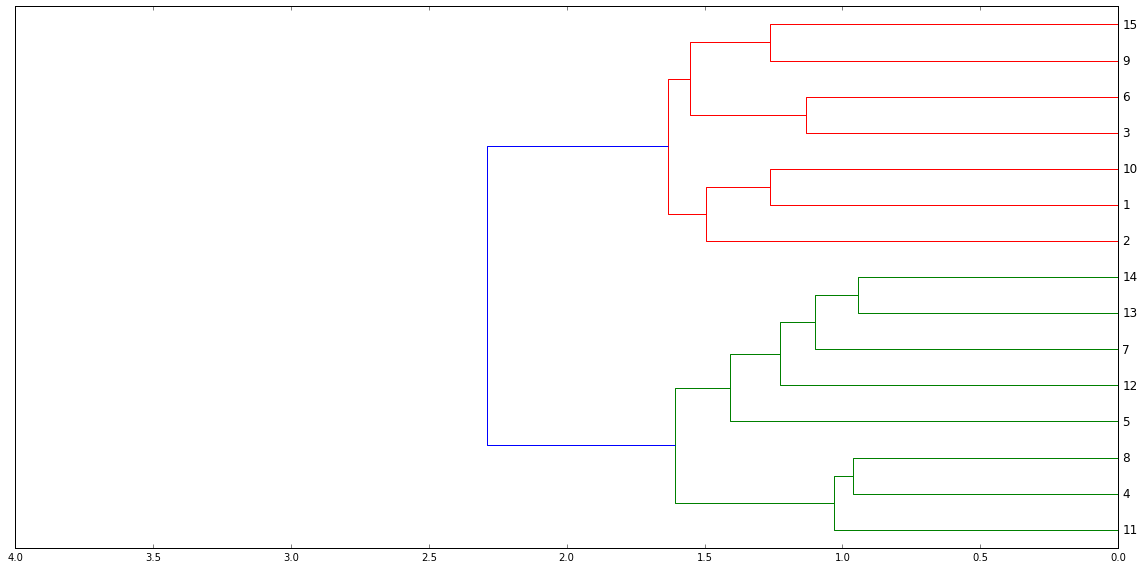

In [19]:
targetword = 'very'

coOc_TFdict=make_coOcVectors_TFdict(tokens_clean[f], [targetword], 4)

# Covert Dict of Co-Occurrances to DTM
coCoDictList = []
for key in coOc_TFdict[targetword].keys():
    coCoDictList.append(coOc_TFdict[targetword][key])

dv = DictVectorizer(sparse=True)
dtm = dv.fit_transform(coCoDictList)

dist = 1 - cosine_similarity(dtm)

linkage_matrix = ward(dist)

names=list(coOc_TFdict[targetword].keys())

print('Number of Occurences: '+str(len(names)))
print(targetword)
# match dendrogram to that returned by R's hclust()
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

dendrogram(linkage_matrix, orientation="left", labels=names, color_threshold=2.0)

#dendrogram(linkage_matrix, orientation="left", labels=names)

plt.xlim([4.0,0.0])
plt.tight_layout()  # fixes margins

# plt.show()
# plt.savefig('./protest_temporalAnalysis/'+targetword+'_clustering.pdf')

In [20]:
Z = linkage_matrix

In [21]:
linkage_matrix

array([[ 12.        ,  13.        ,   0.94207218,   2.        ],
       [  3.        ,   7.        ,   0.96014322,   2.        ],
       [ 10.        ,  16.        ,   1.03018343,   3.        ],
       [  6.        ,  15.        ,   1.10113578,   3.        ],
       [  2.        ,   5.        ,   1.13192314,   2.        ],
       [ 11.        ,  18.        ,   1.22601998,   4.        ],
       [  0.        ,   9.        ,   1.26243812,   2.        ],
       [  8.        ,  14.        ,   1.26243812,   2.        ],
       [  4.        ,  20.        ,   1.40690263,   5.        ],
       [  1.        ,  21.        ,   1.49652375,   3.        ],
       [ 19.        ,  22.        ,   1.55120921,   4.        ],
       [ 17.        ,  23.        ,   1.60891776,   8.        ],
       [ 24.        ,  25.        ,   1.63162569,   7.        ],
       [ 26.        ,  27.        ,   2.28793113,  15.        ]])

In [22]:

max_d = 2.0 # Same as color_threshold
clusters = fcluster(Z, max_d, criterion='distance')

clusters
print("Number of clusters: ",max(clusters))

Number of clusters:  2


Color Threshold - Need to Standardize across the Target Words


Colors all the descendent links below a cluster node k the same color if k 
is the first node below the cut threshold t. All links connecting nodes with distances greater than 
or equal to the threshold are colored blue. 
If t is less than or equal to zero, all nodes are colored blue.

In [23]:
# color_threshold default
0.7*max(linkage_matrix [:,2])

1.6015517897747447

### Print Plot for all Target Words in a Single Document

17 November 1957_Loving Your Enemies.txt
not
Number of Occurences:  22
Number of clusters:  4
Number of clusters Normalized:  0.181818181818
when
Number of Occurences:  21
Number of clusters:  4
Number of clusters Normalized:  0.190476190476
very
Number of Occurences:  15
Number of clusters:  2
Number of clusters Normalized:  0.133333333333
good
Number of Occurences:  13
Number of clusters:  4
Number of clusters Normalized:  0.307692307692
even
Number of Occurences:  12
Number of clusters:  3
Number of clusters Normalized:  0.25
just
Number of Occurences:  12
Number of clusters:  2
Number of clusters Normalized:  0.166666666667
most
Number of Occurences:  12
Number of clusters:  3
Number of clusters Normalized:  0.25
more
Number of Occurences:  11
Number of clusters:  2
Number of clusters Normalized:  0.181818181818
enough
Number of Occurences:  11
Number of clusters:  2
Number of clusters Normalized:  0.181818181818
great
Number of Occurences:  11
Number of clusters:  2
Number of clus

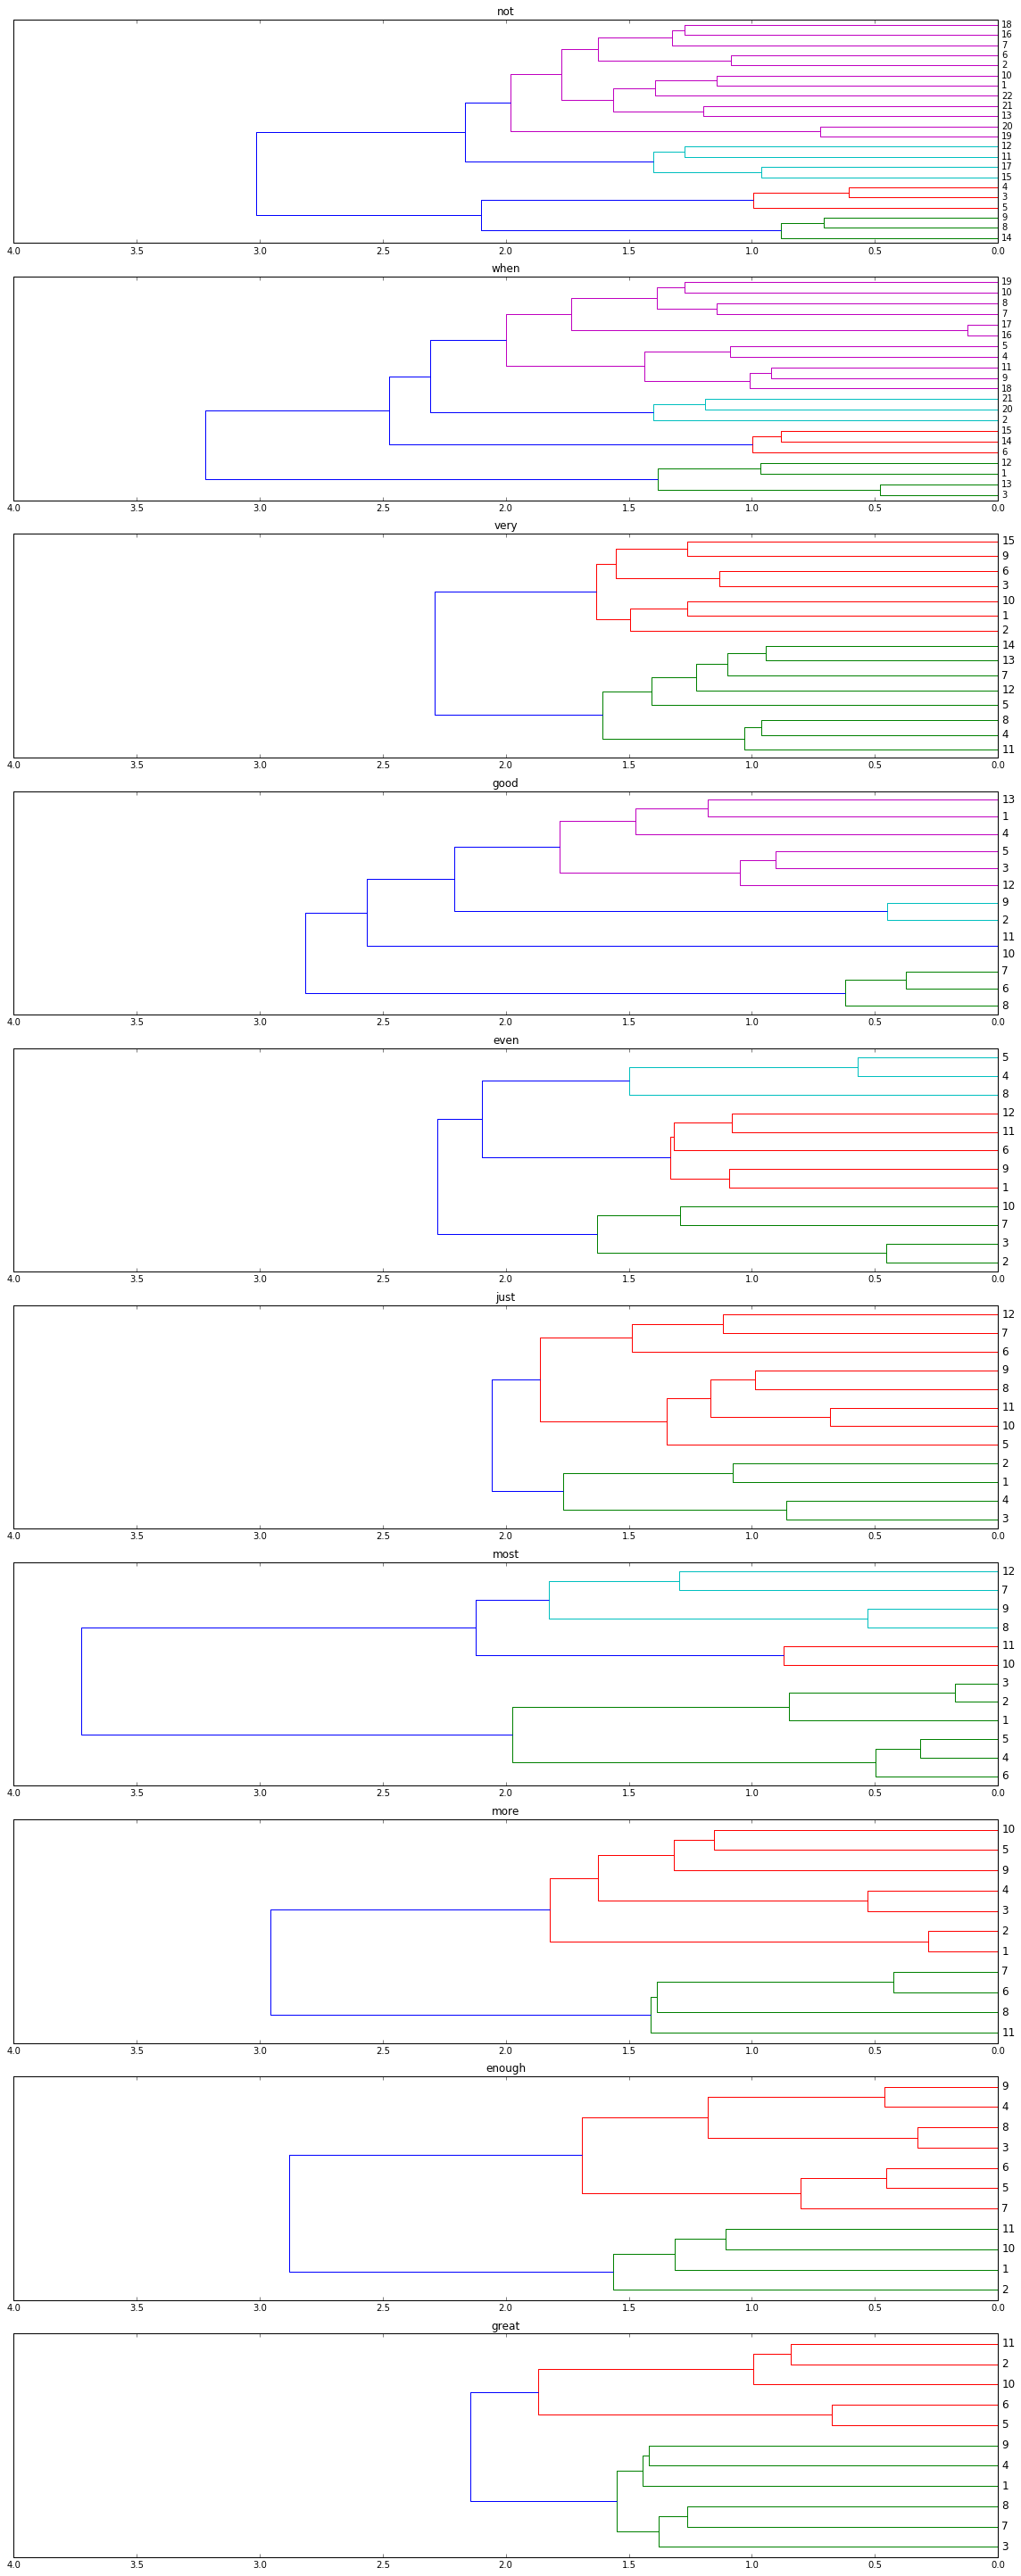

In [24]:
# File to Be Analyzed: f
print(f)
coOc_TFdict=make_coOcVectors_TFdict(tokens_clean[f], targetwords[f], 4)
i = 1
plt.figure(num=None, figsize=(16, 4*len(targetwords)), dpi=80, facecolor='w', edgecolor='k')

# Distance Threshold for Cluster Cutoff
max_d = 2.0

cluster_count = []
cluster_count_norm = []

for target in targetwords[f]:
    print(target)
    # Covert Dict of Co-Occurrances to DTM
    coCoDictList = []
    for key in coOc_TFdict[target].keys():
        coCoDictList.append(coOc_TFdict[target][key])
    dv = DictVectorizer(sparse=True)
    dtm = dv.fit_transform(coCoDictList)
    dist = 1 - cosine_similarity(dtm)
    linkage_matrix = ward(dist)
    names=list(coOc_TFdict[target].keys())

    # Get number of distinct clusters
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    
    cluster_count.append(max(clusters))
    cluster_count_norm.append(max(clusters)/len(names))
    
    print('Number of Occurences: ', len(names))
    print("Number of clusters: ", max(clusters))
    print("Number of clusters Normalized: ", max(clusters)/len(names))
    
    # Plot Clusters for Each Word in Targetword List
    plt.subplot(len(targetwords), 1, i)
    dendrogram(linkage_matrix, orientation="left", labels=names, color_threshold=max_d)
    plt.xlim([4.0,0.0]) # Standard Scale for all Plots
    plt.title(target)
    plt.tight_layout()  # fixes margins

    i += 1

In [25]:
# Signal for this Document, average number of "uses" the Top 10 Adj/Adv have in the document. To Do -- Average across 
# multiple documents. Could just concatenate the documents into one long string.
# Should this be normalized by the number of occurrences of that word?

print(mean(cluster_count))
print(mean(cluster_count_norm))


2
0.202544122544


## Built as Function for temporal_viz File

In [26]:
def getWordUsage(tokenlist,targetwords,windowSize):
    # Make sure 'nt' converted to 'not' in target word list
    targetwords = [word for word in targetwords if word != 'nt']
    
    coOc_TFdict=make_coOcVectors_TFdict(tokenlist, targetwords, windowSize)
   
    # Distance Threshold for Cluster Cutoff
    max_d = 2.0

    cluster_count = []
    cluster_count_norm = []

    for target in targetwords:
        # Covert Dict of Co-Occurrances to DTM
        coCoDictList = []
        for key in coOc_TFdict[target].keys():
            coCoDictList.append(coOc_TFdict[target][key])
        dv = DictVectorizer(sparse=True)
        dtm = dv.fit_transform(coCoDictList)
        dist = 1 - cosine_similarity(dtm)
        linkage_matrix = ward(dist)
        names=list(coOc_TFdict[target].keys())

        # Get number of distinct clusters
        clusters = fcluster(linkage_matrix, max_d, criterion='distance')

        cluster_count.append(max(clusters))
        cluster_count_norm.append(max(clusters)/len(names))

    return (mean(cluster_count), mean(cluster_count_norm))

In [27]:
start=datetime.datetime.now()
usage=[]
for file in fileData.fileName:
    print(file)
    use = getWordUsage(tokenLists[file],targetwords[file],4)
    usage.append(use) # Returns %pos, %neg, #pos, #
print(datetime.datetime.now()-start)

28 February 1954_Rediscovering Lost Values_Detroit, Mich.txt
4 November 1956_Paul's Letter to American Christians_Dexter Avenue Baptist Church, Montgomery, Alabama.txt
17 May 1957_Give Us the Ballot_Washington, D.C.txt
17 November 1957_Loving Your Enemies.txt
23 June 1963_Speech at the Great March on Detroit_Cobo Hall in Detroit.txt
18 September 1963_Eulogy for the Martyred Children_UNK.txt
25 March 1965_Our God is Marching On!_Montgomery, Ala.txt
4 July 1965_The American Dream_Ebenezer Baptist Church, Atlanta, Georgia.txt
5 June 1966_Guidelines for a Constructive Church_Ebenezer Baptist Church, Atlanta, Georgia.txt
4 April 1967_Beyond Vietnam_New York, N.Y.txt
9 April 1967_The Three Dimensions Of A Complete Life_New Covenant Baptist Church Chicago Illinois.txt
11 June 1967_A Knock at Midnight_UNK.txt
27 August 1967_Why Jesus Called A Man A Fool_Mount Pisgah Missionary Baptist Church, Chicago, Illinois.txt
4 February 1968_The Drum Major Instinct_UNK.txt
31 March 1968_Remaining Awake Th

In [28]:
usage

[(4, 0.19437551534552758),
 (1, 0.14846542346542346),
 (1, 0.20371794871794874),
 (2, 0.19485181485181485),
 (2, 0.17584073471285747),
 (1, 0.29984848484848486),
 (4, 0.19291549953314657),
 (4, 0.18519561492858705),
 (2, 0.21729005562338896),
 (3, 0.16230208197599502),
 (4, 0.15647913982153111),
 (2, 0.19405651892864167),
 (3, 0.17222070553967106),
 (3, 0.19839272177000372),
 (2, 0.16440595223489959)]

In [29]:
# Extracts the average number of uses/clusters for the set of target words in documents
u=[use[0] for use in usage]
fileData['uses']=u

In [30]:
# Extracts the average number of uses/clusters normalized by number of occurrences
u=[use[1] for use in usage]
fileData['uses_normalized']=u